## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").

* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
### Import needed packages

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.misc import imsave
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### Compute Camera calibration matrix and distortion coefficients

Using a set of chessboard images ...

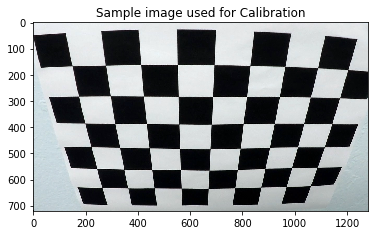

In [2]:
sample_img = cv2.imread('../camera_cal/calibration2.jpg')
_ = plt.imshow(sample_img)
_ = plt.title("Sample image used for Calibration")

In [3]:
# Number of inside corners along the x and y axis
nx = 9
ny = 6 

# Arrays to store object points and image points from all images
objpoints = []
imgpoints = []

# Prepare object points in this format (0,0,0), (1,0,0), ..., (7,5,0)
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Read calibration images one by one
images = glob.glob('../camera_cal/calib*.jpg')

print("Number of calibdation images: ", len(images))
imgs_ = []

Number of calibdation images:  20


In [4]:
# Step through the list and search for chessboard corners
for index, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        imgs_.append(img)

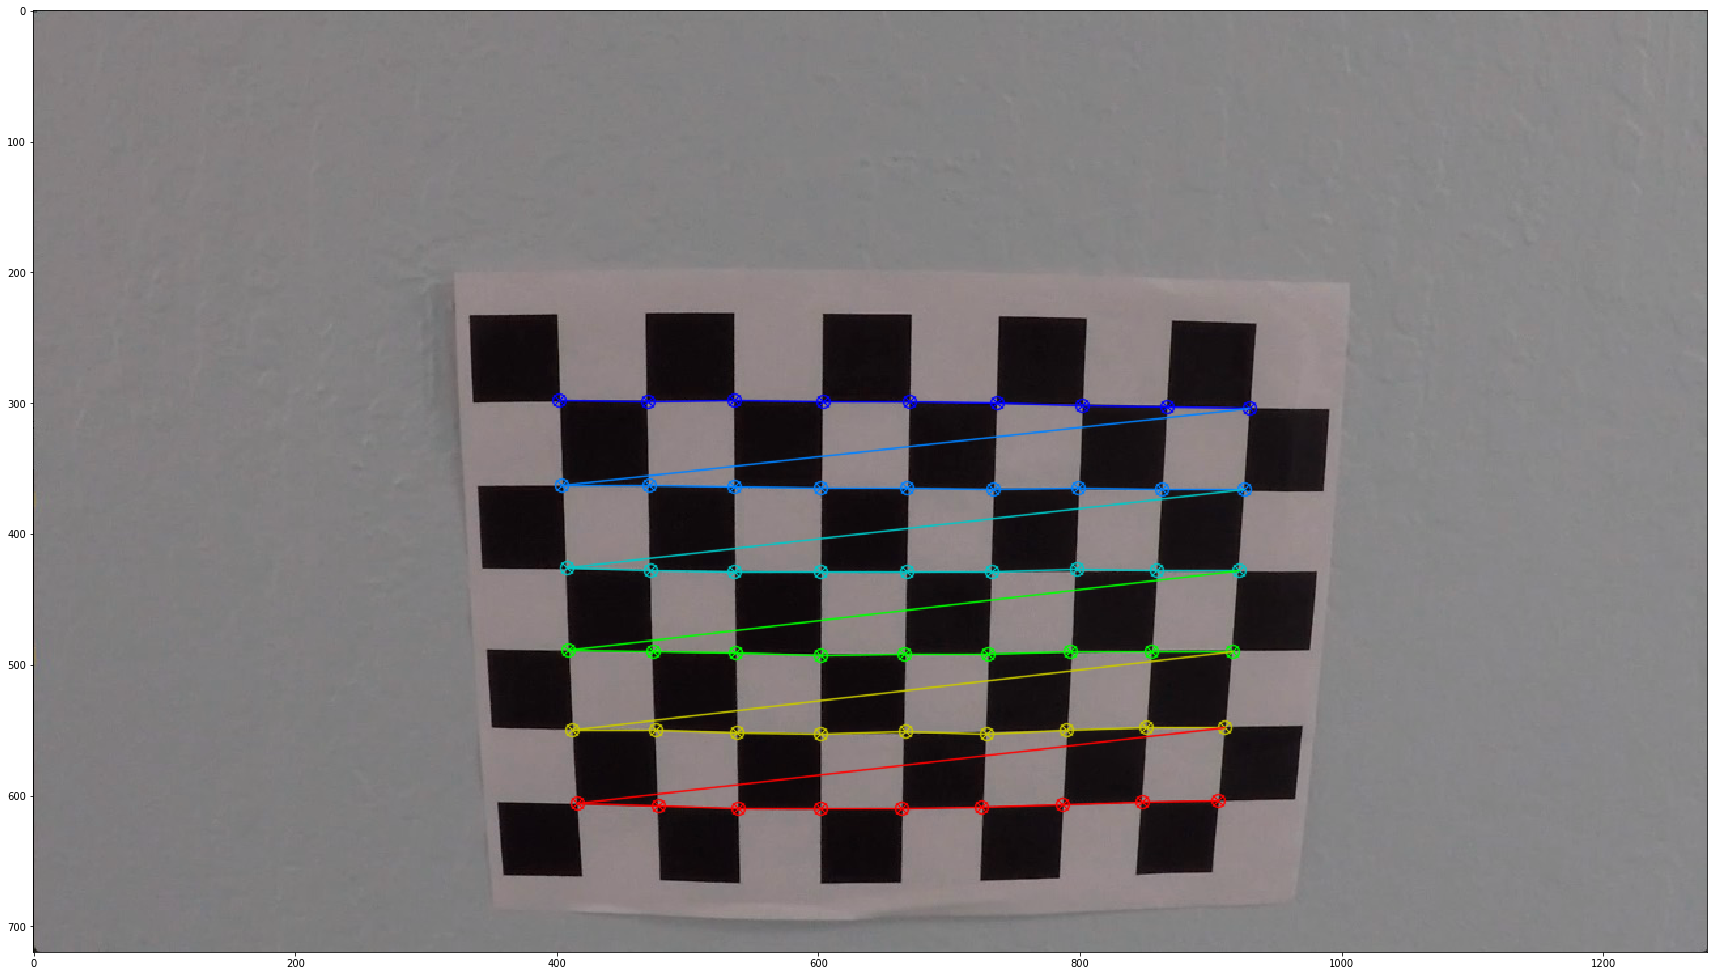

In [5]:
plt.figure(figsize=(30, 30))
_ = plt.imshow(imgs_[0])

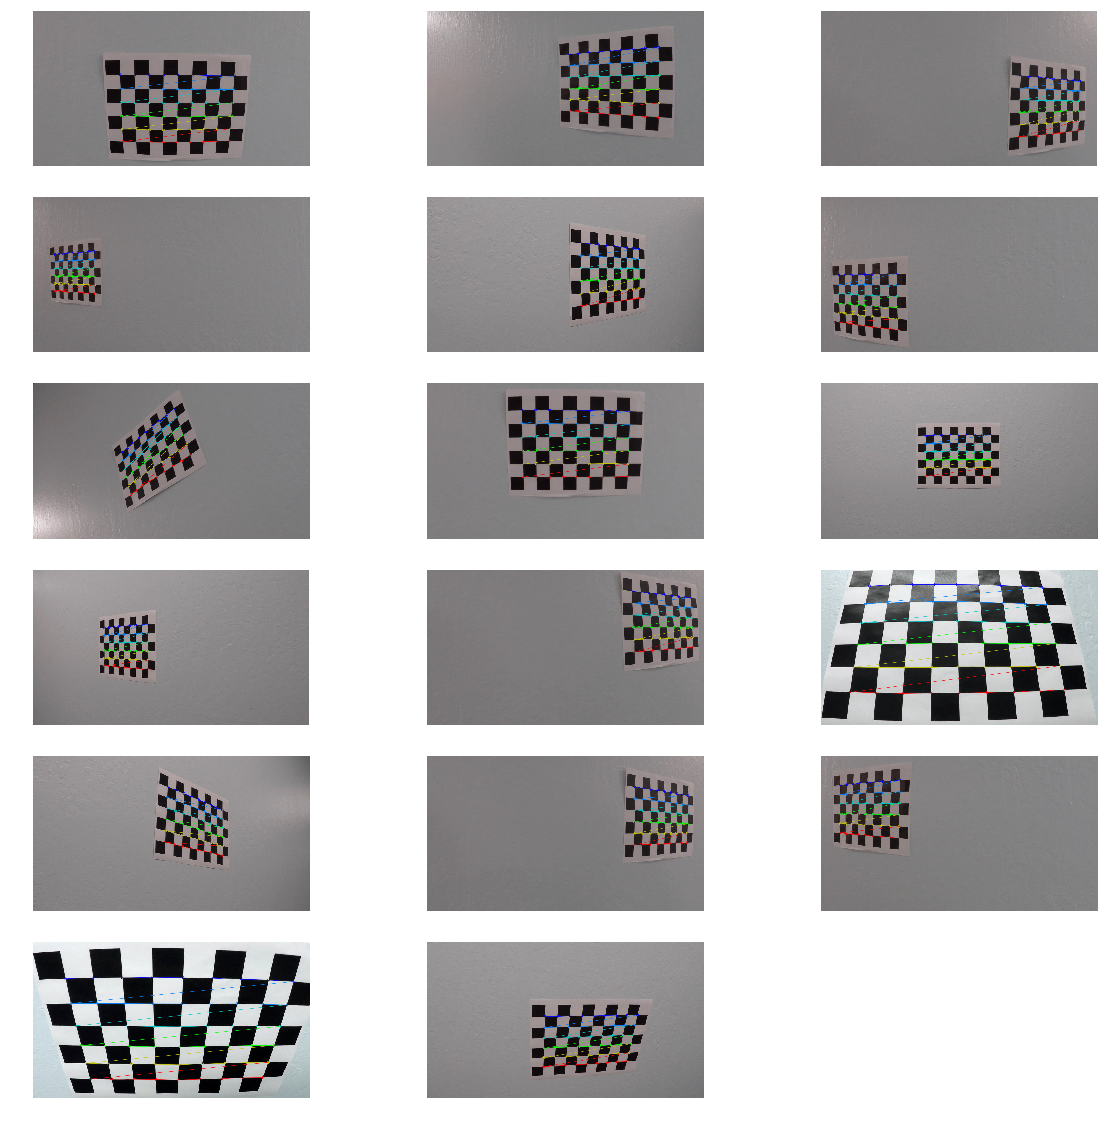

In [6]:
plt.figure(figsize=(20, 20))
for i in range(17):
    plt.subplot(6,3,i+1)
    plt.axis('off')
    plt.imshow(imgs_[i])
    

### Calibrate distorted chess board image

In [7]:
# Read image and retrieve the size
img = cv2.imread('../camera_cal/calibration1.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

size = (gray.shape[1], gray.shape[0])

# Calibrate the camera using the derived object points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, 
                                                   imgpoints, 
                                                   size, 
                                                   None, 
                                                   None)

# undistort the image using the derived calibration parameters
img_undist = cv2.undistort(img, mtx, dist, None, mtx)

(-0.5, 1279.5, 719.5, -0.5)

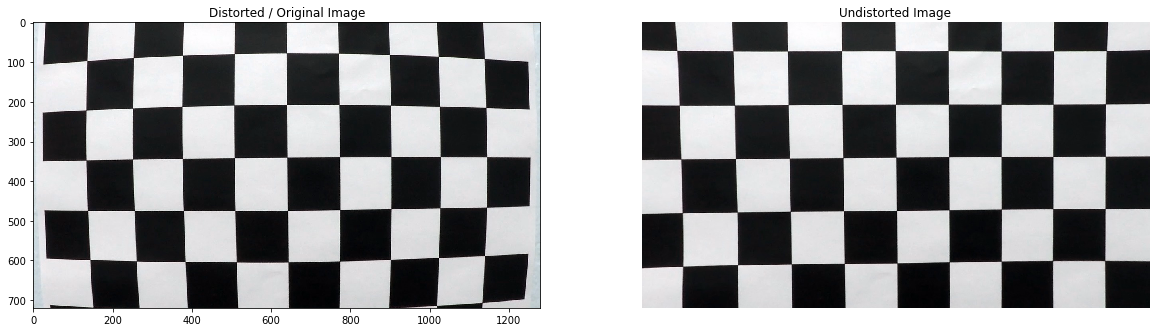

In [8]:
# Display the distorted image (left) and undistorted image (right)
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))
ax1.imshow(img)
ax1.set_title('Distorted / Original Image')
ax2.imshow(img_undist)
ax2.set_title('Undistorted Image')
plt.axis('off')

### Calibrate distorted road image

(-0.5, 1279.5, 719.5, -0.5)

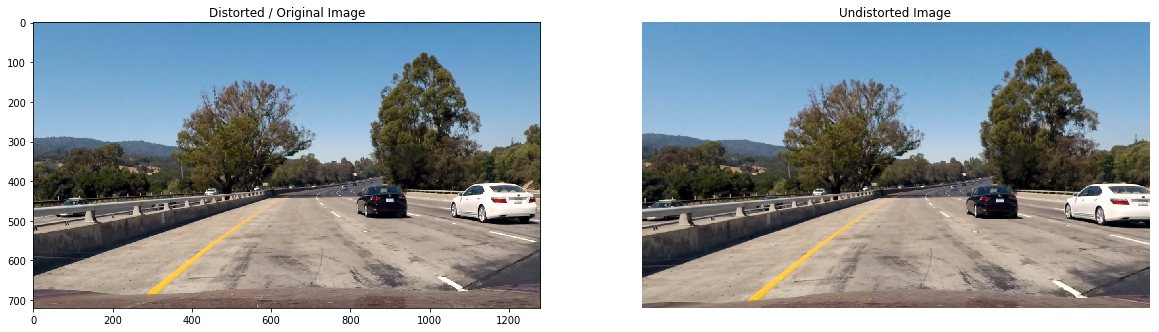

In [9]:
# Read image and retrieve the size
img = cv2.imread('../test_images/test1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# undistort the image using the derived calibration parameters
img_undist = cv2.undistort(img, mtx, dist, None, mtx)

# Display the distorted image (left) and undistorted image (right)
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))
ax1.imshow(img)
ax1.set_title('Distorted / Original Image')
ax2.imshow(img_undist)
ax2.set_title('Undistorted Image')
plt.axis('off')

### Pickle camera matrix and other params for future use ...

In [10]:
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_params_pickle.p", "wb" ) )

Read pickled calibration params

In [11]:
with open('calibration_params_pickle.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

### Color and Gradient Thresholding

In [12]:
def gradient_thresh(img, plot=False):
    '''
    Apply sobel filter in the horizontal direction to get vertical lines
    that represent the lanes.
    
    The sobel filter is applied in the HLS domain on the L channel, since 
    it is mainly dependent on intensity values
    
    Input:
        img: Image in RGB
    '''
    # Convert color space to HLS
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    # Get the L Channel
    l_ch = hls_img[:,:,1]
    # Apply Sobel filter in horizontal direction
    sobelx = cv2.Sobel(l_ch, cv2.CV_64F, 1, 0)
    # Take absolute value of the sobel_x filter
    abs_sobelx = np.absolute(sobelx)
    # Scale the sobel 
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Apply upper and lower thresholds on the x-direvatives (gradient strength)
    thresh_min = 40
    thresh_max = 100
    # Select pixels based on gradient strength
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= thresh_min) & (scaled_sobelx <= thresh_max)] = 1
    
    if plot:
        plt.imshow(sxbinary, cmap='gray')
        
    return sxbinary
    

(-0.5, 1279.5, 719.5, -0.5)

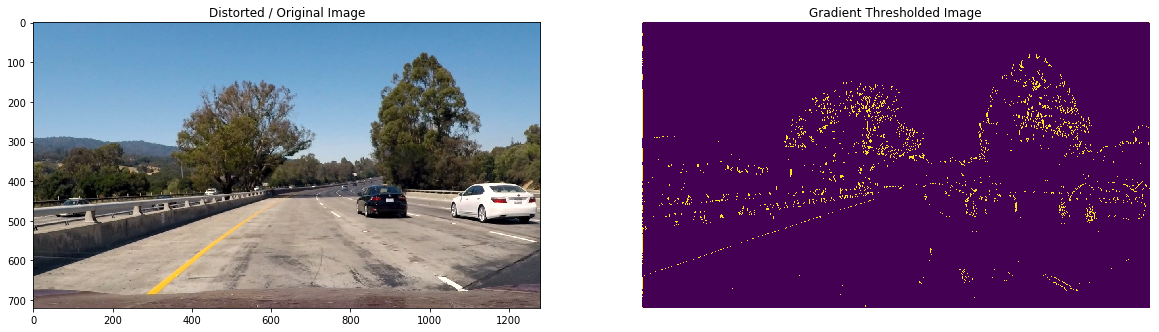

In [13]:
grad = gradient_thresh(img)
# Display the distorted image (left) and undistorted image (right)
f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,20))
ax1.imshow(img)
ax1.set_title('Distorted / Original Image')
ax2.imshow(grad)
ax2.set_title('Gradient Thresholded Image')
plt.axis('off')

In [14]:
def color_thresh(img, plot=False):
    '''
    Apply thresholding on the Saturation channel in HLS space
    
    Input:
        img: Image in RGB
        
    '''
    # Convert color space to HLS
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    # Get the L Channel
    s_ch = hls_img[:,:,2]
    
    s_thresh_min = 140
    s_thresh_max = 255
    
    s_binary = np.zeros_like(s_ch)
    s_binary[(s_ch >= s_thresh_min) & (s_ch <= s_thresh_max)] = 1
    
    if plot:
        plt.imshow(s_binary, cmap='gray')
    
    return s_binary

In [15]:
def combine_thresholds(grad, color):
    '''
    Combine color thresholding and gradient thresholding
    '''
    
    combined_binary = np.zeros_like(grad)
    combined_binary[(color == 1) | (grad == 1)] = 1
    
    return combined_binary


(-0.5, 1279.5, 719.5, -0.5)

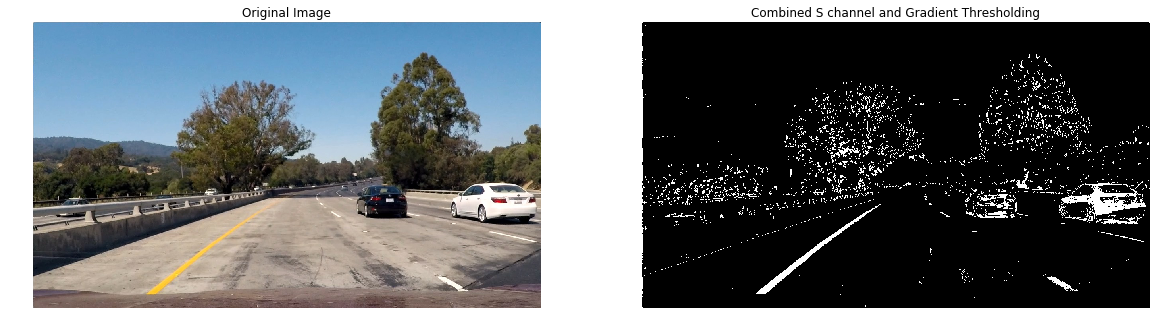

In [16]:
# Apply color and gradient thresholding on a test image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))

# Read image and retrieve the size
img = cv2.imread('../test_images/test1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

ax1.set_title('Original Image')
ax1.imshow(img)

cobined_binary_color_grad_img = combine_thresholds(gradient_thresh(img), color_thresh(img))

ax2.set_title('Combined S channel and Gradient Thresholding')
ax2.imshow(cobined_binary_color_grad_img, cmap='gray')
ax1.axis('off')
ax2.axis('off')

### Perspective Transform

In [17]:
def warp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return Minv, warped

In [18]:
def draw_straight_lines(img, src, dst):
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    _, warped = warp(img, src, dst)
    warp_result = []
    undist_result = []
    for i in range(len(src)-1):
        cv2.line(undistorted, (src[i][0], src[i][1]), (src[i+1][0], src[i+1][1]), color=[0,255,0], thickness=3)
        undist_result.append(undistorted)

        cv2.line(warped, (dst[i][0], dst[i][1]), (dst[i+1][0], dst[i+1][1]), color=[255,0,0], thickness=3)
        warp_result.append(warped)
        
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.axis('off')
    ax1.imshow(undist_result[-1])
    ax2.axis('off')
    ax2.imshow(warp_result[-1])

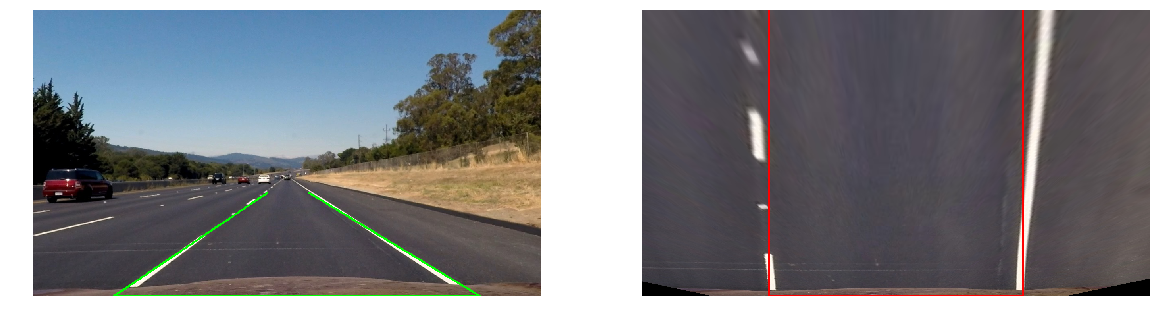

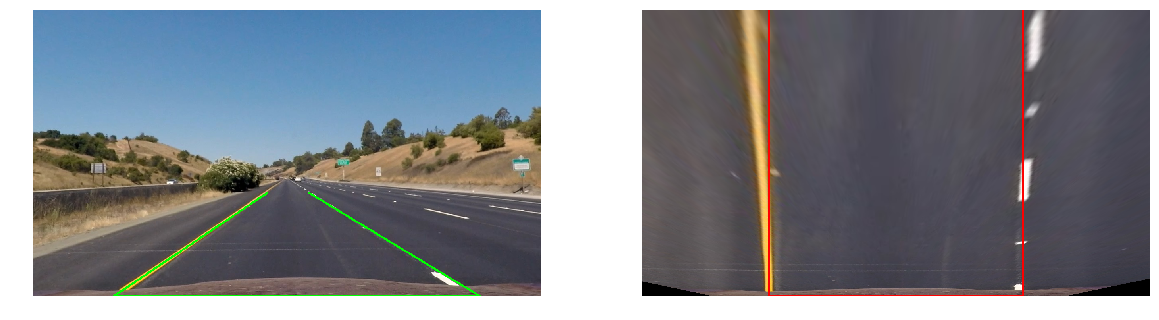

In [19]:
imgs = glob.glob('../test_images/straight_lines*.jpg')
i = 0
fig = []

for fname in imgs:
    img = mpimg.imread(fname)
    img_size = (img.shape[1], img.shape[0])
    
    # Choose 4 points on the original image needed for the Perspective Transform
    src = np.float32([[(img_size[0] / 2) - 50, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    
    # Location of the 4 points in the destination image after the perspective transform
    dst = np.float32([[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    
    draw_straight_lines(img, src, dst)

In [20]:
img_size = (img.shape[1], img.shape[0])

src = np.float32([[(img_size[0] / 2) - 50, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 50, img_size[1]],
    [(img_size[0] / 2 + 50), img_size[1] / 2 + 100]])

dst = np.float32([[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    
print(src)
print(dst)

[[  590.           460.        ]
 [  203.33332825   720.        ]
 [ 1116.66662598   720.        ]
 [  690.           460.        ]]
[[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


In [21]:
def find_lanes(binary_warped):
    '''
    
    Input:
        img: Binary, warped image
    '''

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 8
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
        
    return leftx, lefty, rightx, righty, out_img
    

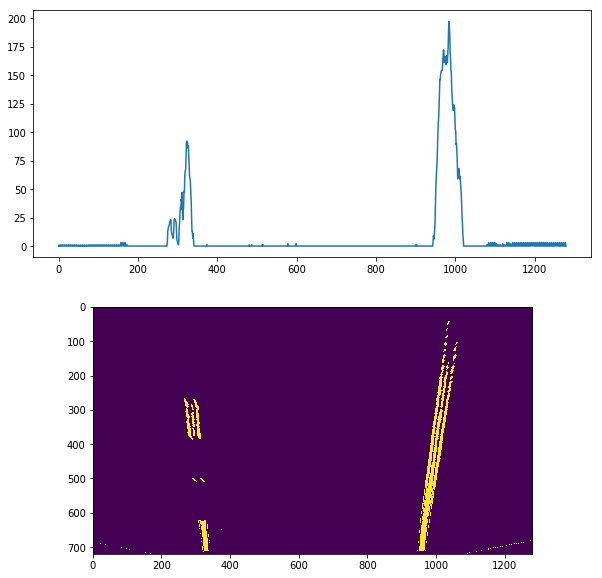

In [22]:
test_img = mpimg.imread('../test_images/straight_lines2.jpg')
undist = cv2.undistort(test_img, mtx, dist, None, mtx)
Minv, warped = warp(undist, src, dst)
img_color_thresh = color_thresh(warped)
img_grad_thresh = gradient_thresh(warped)    
binary_warped = combine_thresholds(color=img_color_thresh, grad=img_grad_thresh)

histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
_ = ax1.plot(histogram)
_ = ax2.imshow(binary_warped)

In [23]:
def polyfit(binary_warped, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return ploty, left_fitx, right_fitx

In [24]:
def curvature(ploty, leftx, lefty, rightx, righty):
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    return left_curverad, right_curverad

In [25]:
def plot_sliding_window(test_img):
    undist = cv2.undistort(test_img, mtx, dist, None, mtx)
    Minv, warped = warp(undist, src, dst)
    img_color_thresh = color_thresh(warped)
    img_grad_thresh = gradient_thresh(warped)    
    binary_warped = combine_thresholds(color=img_color_thresh, grad=img_grad_thresh)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    leftx, lefty, rightx, righty, out_img = find_lanes(binary_warped)
    ploty, left_fitx, right_fitx = polyfit(binary_warped, leftx, lefty, rightx, righty)
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Write the results on images using OpenCV 
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_size = 1.5
    color = (255,255,255)
    text_left = "{:6.5}y^2+{:6.5}y+{:6.5}".format(left_fit[0],left_fit[1],left_fit[2])
    cv2.putText(out_img, text_left, (20, 100), font, font_size, color, 2)
    text_right = "{:6.5}y^2+{:6.5}y+{:6.5}".format(right_fit[0],right_fit[1],right_fit[2])
    cv2.putText(out_img, text_right, (360, 600), font, font_size, color, 2)    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    plt.plot(left_fitx, ploty, color='yellow',linewidth=2.0)
    plt.plot(right_fitx, ploty, color='yellow',linewidth=2.0)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.axis('off')
    plt.imshow(out_img)
    # To save the image uncomment below
#     plt.savefig('./output_images/color_fit_lines.jpg')
    return out_img

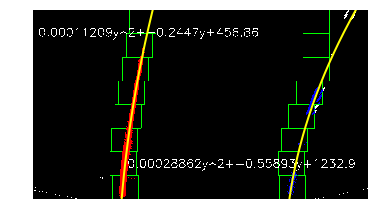

In [26]:
# Test image
test_img = mpimg.imread('../test_images/test3.jpg')
out_img = plot_sliding_window(test_img)

In [27]:
def offset(result, pts_left, pts_right):
    xm_per_pix = 3.7 / 700
    lane_difference = pts_right[0, pts_right[0,:,1].argmax(), 0] - pts_left[0, pts_left[0,:,1].argmax(), 0]
    offset_center = (lane_difference - result.shape[1]/2) * xm_per_pix
    return offset_center

def visualization(warped, ploty, left_fitx, right_fitx, Minv, undist, left_curverad, right_curverad):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 255))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    # Write the results on images using OpenCV 
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_size = 1.5
    color = (255,255,255)
    text = "Left Curvature: {} m".format(round(left_curverad, 3))
    cv2.putText(result, text, (400, 50), font, font_size, color, 2)
    text = "Right Curvature: {} m".format(round(right_curverad, 3))
    cv2.putText(result, text, (400, 100), font, font_size, color, 2)
    center_offset = offset(result, pts_left, pts_right)
    text = "Vehicle is {}m left of center".format(round(center_offset, 3))
    cv2.putText(result, text,(400,150), font, font_size, color, 2)

    return result

In [28]:
def detect_lanes(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    Minv, warped = warp(undist, src, dst)
    img_color_thresh = color_thresh(warped)
    img_grad_thresh = gradient_thresh(warped)    
    binary_warped = combine_thresholds(color=img_color_thresh, grad=img_grad_thresh)    
    leftx, lefty, rightx, righty, out_img = find_lanes(binary_warped)
    ploty, left_fitx, right_fitx = polyfit(binary_warped, leftx, lefty, rightx, righty)
    left_curverad, right_curverad = curvature(ploty, leftx, lefty, rightx, righty)
    return visualization(binary_warped, ploty, left_fitx, right_fitx, Minv, undist, left_curverad, right_curverad)

def process_image(img):
    return detect_lanes(img, mtx, dist)


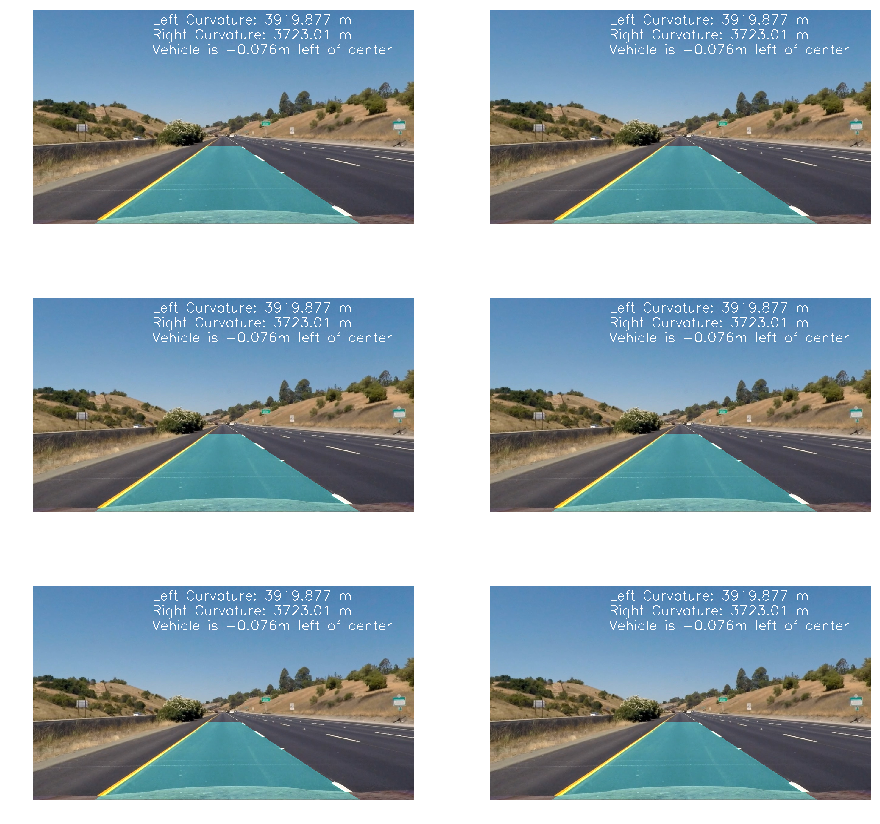

In [29]:
images = glob.glob('../test_images/test*.jpg')

plt.figure(figsize=(15, 15))
for i in range(6):
    plt.subplot(3,2,i+1)
    plt.axis('off')
    plt.imshow(detect_lanes(img, mtx, dist))

In [30]:
video_output = '../../advanced_lane_finding/output.mp4'
clip1 = VideoFileClip("../project_video.mp4")
video_clip = clip1.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ../../advanced_lane_finding/output.mp4
[MoviePy] Writing video ../../advanced_lane_finding/output.mp4


100%|█████████▉| 1260/1261 [02:06<00:00,  9.96it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../../advanced_lane_finding/output.mp4 

CPU times: user 4min 54s, sys: 9.31 s, total: 5min 4s
Wall time: 2min 7s
